<a href="https://colab.research.google.com/github/WoobeenJeong/bioinfo1_jwb/blob/main/Project_005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Data mounting**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2) Environment setting**

In [ ]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

In [ ]:
!conda install -y bedtools bioawk samtools

**3) Data loading & check**

In [5]:
%cd /content/drive/MyDrive/binfo1-work

/content/drive/MyDrive/binfo1-work


In [ ]:
!ls -al /content/drive/MyDrive/binfo1-work/

In [ ]:
!md5sum /content/drive/MyDrive/binfo1-work/*

**4) Background setting**

In [6]:
%cd /content/drive/MyDrive/binfo1-work
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

/content/drive/MyDrive/binfo1-work


**5) Target region on CLIP-seq using gencode.gtf**

먼저 GTF파일은 genecode로부터 M32버전이 (2023.02월에) 나왔으며  
M32(GRCm39) Refseq 자료 중 chr9에 대해 확인 할 것  
NCBI RefSeq에서도 Mus musculus strain C57BL/6J chromosome 9, GRCm39 존재

1) C=Shannon’s entrophy를 CRES: Crosslinking-induced reverse transcription error score로 가져감  
2) 이때, insertion은 무시 substitution과 deletion고려  
3) FDR은 permutation으로 구함   
4) Read는 rRNA,tRNA,adapte제외하고 GSNAP의 Refseq에 align  
5) 이를 바탕으로, 먼저 CRES(0.8) 상 low depth positio이 130 reads 이하  
6) LOESS smoothing (regression) a=0.5사용 medium depth positon 250 read이하  
7) FDR(0.001)상 high depth position >250 read 사용  

In [ ]:
!gzip -d gencode.vM32.annotation.gtf.gz

gzip: gencode.vM32.annotation.gtf.gz: No such file or directory


In [ ]:
!grep 'chr9' gencode.vM32.annotation.gtf > gencode.vM32.chr9.gtf

In [ ]:
!head gencode.vM32.chr9.gtf

In [ ]:
!awk -F'\t' '{if ($3 == "gene") print $4}' gencode.vM32.chr9.gtf | sort -n | head -n 1
!awk -F'\t' '{if ($3 == "gene") print $5}' gencode.vM32.chr9.gtf | sort -n | tail -n 1

3038669
124252776


In [ ]:
!samtools view -b -o CLIP-let7g.bam CLIP-35L33G.bam chr9:3038669-124252776
!samtools view CLIP-let7g.bam | wc -l

1696165


In [ ]:
!samtools index CLIP-let7g.bam

In [ ]:
!samtools view -F 16 CLIP-let7g.bam | wc -l

905001


(+)stand만 추출, 절반이 사라짐

In [ ]:
!samtools view -b -F 0x10 -o forward-CLIP-let7g.bam CLIP-let7g.bam

In [ ]:
!samtools view -f 16 forward-CLIP-let7g.bam  | wc -l

0


In [ ]:
!samtools view -F 16 forward-CLIP-let7g.bam  | wc -l

905001


QC는 상관없을 것으로 생각되나, secondary와 supplimentary read는 제거해야함 = secondary는 하나의 서열이 다른 곳에도 mapping될 수 있음을 고려, 

In [ ]:
!samtools flagstat forward-CLIP-let7g.bam | head

905001 + 0 in total (QC-passed reads + QC-failed reads)
339889 + 0 secondary
189 + 0 supplementary
0 + 0 duplicates
905001 + 0 mapped (100.00% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped


In [ ]:
!samtools view -b -F 0x900 -o first-forward-CLIP-let7g.bam forward-CLIP-let7g.bam

In [ ]:
!samtools view -F 16 first-forward-CLIP-let7g.bam  | wc -l

564923


estimate가 0.001 이었으니, MAPQ가 30이다.

In [ ]:
!samtools view -q 30 -b first-forward-CLIP-let7g.bam -o check-CLIP-let7g.bam
!wc -l check-CLIP-let7g.bam

73508 check-CLIP-let7g.bam


In [ ]:
!samtools mpileup check-CLIP-let7g.bam 2>/dev/null > check-CLIP-let7g.pileup
!wc -l check-CLIP-let7g.pileup

18224608 check-CLIP-let7g.pileup


In [ ]:
!awk '$2 >= 3038669 && $2 <= 124252714 { print $0; }' check-CLIP-let7g.pileup > check-CLIP-let7g-gene.pileup
!tail -n 2 check-CLIP-let7g-gene.pileup

chr9	124220663	N	1	C	2
chr9	124220664	N	1	T$	2


In [7]:
pileup = pd.read_csv('check-CLIP-let7g-gene.pileup', sep='\t', names=['chrom', 'pos', 'ref', 'count', 'basereads', 'quals'])
pileup.tail()

,chrom,pos,ref,count,basereads,quals
18224603,chr9,124220660,N,1,C,@
18224604,chr9,124220661,N,1,C,C
18224605,chr9,124220662,N,1,C,C
18224606,chr9,124220663,N,1,C,2
18224607,chr9,124220664,N,1,T$,2


count의 개수가 최대 / 최소 얼마이고 볼 만한 수준인지 확인

In [ ]:
len(np.unique(pileup['count']))

1740

In [ ]:
pileup['count'].describe()

count    1.822461e+07
mean     1.073809e+01
std      4.920374e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      7.994000e+03
Name: count, dtype: float64

위를 보면 알수 있듯이 한 75%까지는 10개정도만 count되어 있는데, 무려 7993 read가 count되는 경우도 있음.  
이경우는 좀 궁금하긴 하다만, 너무 크기 때문에, threshold <=50 reads로 두고 진행   
(Shannon에서 depth 50으로 했으므로)

In [8]:
f50pileup = pileup[pileup['count'] > 50]

In [ ]:
len(np.unique(f50pileup['count']))

1689

In [ ]:
len(np.unique(f50pileup['pos']))

534478

In [ ]:
f50pileup['count'].describe()

count    534478.000000
mean        140.538063
std         251.364587
min          51.000000
25%          58.000000
50%          72.000000
75%         108.000000
max        7994.000000
Name: count, dtype: float64

In [ ]:
max(f50pileup['pos']),min(f50pileup['pos'])

(123421315, 3359542)

match와 substitution, deletion을 사용할 것이므로, 나머지에 해당하는 tag들은 제거.  
**여기서 Deletion은 포함하는 경우를 고려하는 것을 고민할 것**

In [ ]:
toremove = re.compile(r'[<>$*#+-]|[0-9]|\^.')
f50pileup.loc[:, 'matches'] = f50pileup['basereads'].apply(lambda x: toremove.sub('', x))

In [ ]:
f50pileup[['chrom', 'pos', 'matches']].head()

,chrom,pos,matches
21616,chr9,3359542,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21617,chr9,3359543,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21618,chr9,3359544,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
21619,chr9,3359545,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21620,chr9,3359546,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...


Deletion상관 없이 Insertion하고 Hard-clipped read만 제외

In [ ]:
#f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c != 'H' and c != 'I']))
#f50pileup.head()

In [10]:
import itertools

column = f50pileup['matches']
components = column.str.findall('[A-Za-z0-9]') 
all_components = list(itertools.chain(*components))
unique_components = set(all_components)

print(unique_components)

{'T', 'C', 'N', 'G', 'A'}


In [11]:
f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c.upper() in ('A', 'T', 'G', 'C')]))
f50pileup.head()

<ipython-input-11-dc38196e0fd8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c.upper() in ('A', 'T', 'G', 'C')]))


,chrom,pos,ref,count,basereads,quals,matches,base_count
21616,chr9,3359542,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,HDEIHIIGIIIHHIIGAIIIGIBGIHBFGIHE?GIGIHGGHHIBII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21617,chr9,3359543,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IGEIHFG@IIIHHHIGFHIIEIBHIH;GGIHH=GIEIHIGHHIGII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21618,chr9,3359544,N,51,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHBIHIIDHGIGHIIIDIIIDH0HH?DEHFHBBGIGIHIGHHDAII...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,51
21619,chr9,3359545,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IH8IHIIEIGIGHIIFFIIIGI=HIHDGGIHI;GHIIGHGHHI4DI...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21620,chr9,3359546,N,51,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,IHEIHHIEIGGDHIIDHIIIGI7HIH>GHIHI<GIGIFIGDHFCII...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,51


In [ ]:
np.unique(f50pileup['base_count'])

array([   0,    1,    2, ..., 7989, 7990, 7994])

Colab RAM사용 제한 상, 데이터가 날라가는 것을 방지하기 위해 일단 결과 csv 저장

In [ ]:
f50pileup.to_csv('f50pileup.csv', index=True)

In [ ]:
f50pileup.head()

,chrom,pos,ref,count,basereads,quals,matches,base_count
21616,chr9,3359542,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,HDEIHIIGIIIHHIIGAIIIGIBGIHBFGIHE?GIGIHGGHHIBII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21617,chr9,3359543,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IGEIHFG@IIIHHHIGFHIIEIBHIH;GGIHH=GIEIHIGHHIGII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21618,chr9,3359544,N,51,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHBIHIIDHGIGHIIIDIIIDH0HH?DEHFHBBGIGIHIGHHDAII...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,51
21619,chr9,3359545,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IH8IHIIEIGIGHIIFFIIIGI=HIHDGGIHI;GHIIGHGHHI4DI...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21620,chr9,3359546,N,51,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,IHEIHHIEIGGDHIIDHIIIGI7HIH>GHIHI<GIGIFIGDHFCII...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,51


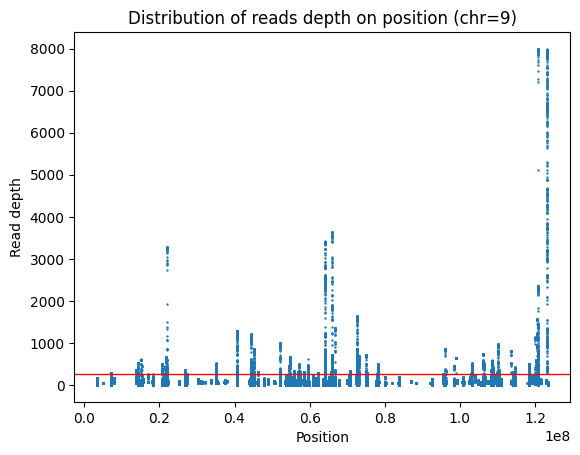

In [16]:
x = f50pileup['pos']
y = f50pileup['base_count']

plt.scatter(x, y,s=0.5)
plt.xlabel('Position')
plt.ylabel('Read depth')
plt.title('Distribution of reads depth on position (chr=9)')
plt.axhline(250, c='red', linewidth=1)
plt.show()

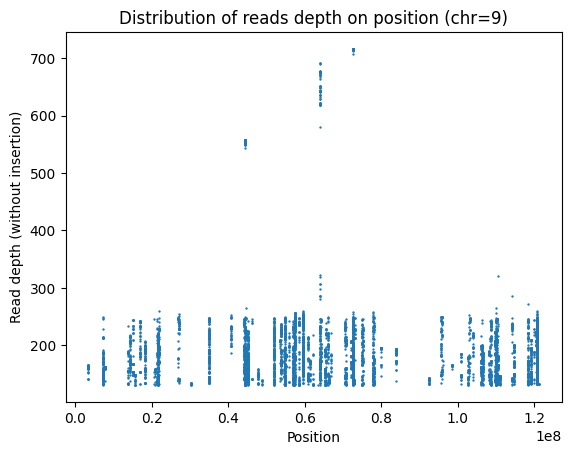

In [17]:
smallpup = f50pileup[(f50pileup['base_count'] > 130) & (f50pileup['base_count'] < 250)]

x = smallpup['pos']
y = smallpup['count']
plt.scatter(x, y,s=0.5)
plt.xlabel('Position')
plt.ylabel('Read depth (without insertion)')
plt.title('Distribution of reads depth on position (chr=9)')
plt.show()

In [ ]:
pup = f50pileup[(f50pileup['base_count'] < 250)]

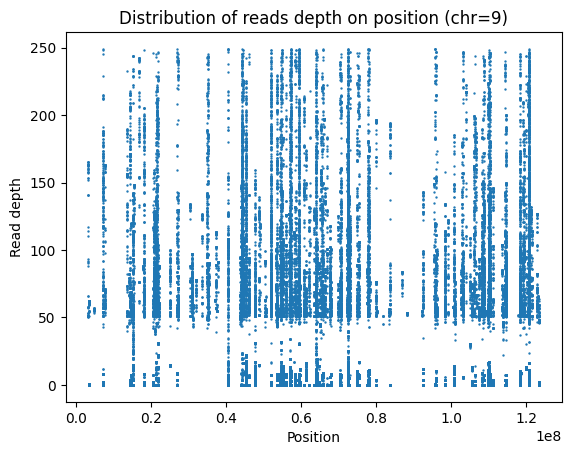

In [ ]:
x = pup['pos']
y = pup['base_count']
plt.scatter(x, y,s=0.5)
plt.xlabel('Position')
plt.ylabel('Read depth')
plt.title('Distribution of reads depth on position (chr=9)')
plt.show()

In [78]:
pup = f50pileup[(f50pileup['base_count'] < 250) & (f50pileup['base_count'] > 50)]

In [79]:
pup['matches'].apply(len)

21616       51
21617       51
21618       51
21619       51
21620       51
            ..
18081219    51
18081221    51
18081222    51
18081223    51
18081224    57
Name: matches, Length: 40671, dtype: int64

한 position에 A,T,G,C가 존재하므로, 확률은 
S={A,T,G,C,N}
p(A), p(T), p(G), p(C) 을 구해서 shannon entropy를 구해야 한다.

In [80]:
for pos, row in pup.iterrows():
    if row['base_count'] == 0:
        pup.loc[pos,'countA'] = '0'
        pup.loc[pos,'countT'] = '0'
        pup.loc[pos,'countG'] = '0'
        pup.loc[pos,'countC'] = '0'
    else:
        pup.loc[pos,'countA'] = (row['matches'].count('A'))/row['base_count']
        pup.loc[pos,'countT'] = (row['matches'].count('T'))/row['base_count']
        pup.loc[pos,'countG'] = (row['matches'].count('G'))/row['base_count']
        pup.loc[pos,'countC'] = (row['matches'].count('C'))/row['base_count']

In [81]:
pup[['countA', 'countT', 'countG', 'countC']].head()

,countA,countT,countG,countC
21616,0.0,0.0,1.0,0.0
21617,0.0,0.0,1.0,0.0
21618,1.0,0.0,0.0,0.0
21619,0.0,0.0,1.0,0.0
21620,0.0,1.0,0.0,0.0


In [ ]:
pup['shannon'] = np.zeros(len(pup))

for i, row in pup.iterrows():
    countA = float(row['countA'])
    countT = float(row['countT'])
    countG = float(row['countG'])
    countC = float(row['countC'])
    
    if countA <= 0.0 or countA >= 1.0:
        pup.loc[i, 'shannon'] += 0
    else:
        pup.loc[i, 'shannon'] += countA * np.log2(countA)
    
    if countT <= 0.0 or countT >= 1.0:
        pup.loc[i, 'shannon'] += 0
    else:
        pup.loc[i, 'shannon'] += countT * np.log2(countT)
    
    if countG <= 0.0 or countG >= 1.0:
        pup.loc[i, 'shannon'] += 0
    else:
        pup.loc[i, 'shannon'] += countG * np.log2(countG)
    
    if countC <= 0.0 or countC >= 1.0:
        pup.loc[i, 'shannon'] += 0
    else:
        pup.loc[i, 'shannon'] += countC * np.log2(countC)


In [83]:
pup[['countA', 'countT', 'countG', 'countC','shannon']].head()

,countA,countT,countG,countC,shannon
21616,0.0,0.0,1.0,0.0,0.0
21617,0.0,0.0,1.0,0.0,0.0
21618,1.0,0.0,0.0,0.0,0.0
21619,0.0,0.0,1.0,0.0,0.0
21620,0.0,1.0,0.0,0.0,0.0


In [87]:
pup['shannon']=-pup['shannon']

<ipython-input-87-c3ecc40fb592>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pup['shannon']=-pup['shannon']


In [88]:
np.unique(pup['shannon'])

array([-0.        ,  0.03775019,  0.03787895, ...,  1.8217662 ,
        1.82363023,  1.87345501])

In [89]:
pup['shannon'].describe()

count    40671.000000
mean         0.053671
std          0.189090
min         -0.000000
25%         -0.000000
50%          0.000000
75%         -0.000000
max          1.873455
Name: shannon, dtype: float64

In [90]:
grouped = pup.groupby('pos')['shannon'].sum().reset_index() 

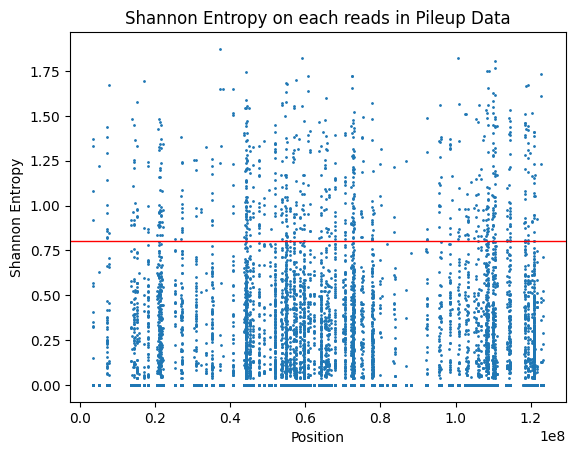

In [91]:
plt.scatter(grouped['pos'], grouped['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy on each reads in Pileup Data')
plt.axhline(0.8, c='red', linewidth=1)
plt.show()

In [64]:
import collections
from scipy.stats import entropy

def shannon(seq):
    tmp = collections.Counter([tmp_base for tmp_base in seq])
    dist = [x/sum(tmp.values()) for x in tmp.values()]
    result = entropy(dist, base=2)
    return result

<ipython-input-65-84df57a27493>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pup2['shannon'] = pup2['matches'].map(lambda x : shannon(x))


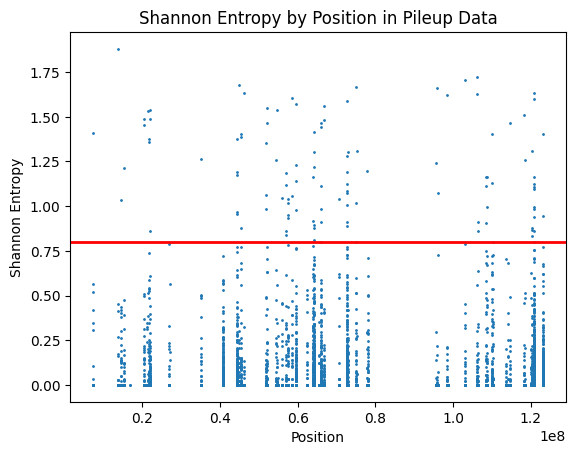

In [65]:
pup2 = pup
pup2['shannon'] = pup2['matches'].map(lambda x : shannon(x))
plt.scatter(pup2['pos'], pup2['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.axhline(0.8, c='red', linewidth=2)
plt.show()

In [92]:
subpup = pup[(pup['shannon'] > .8)]

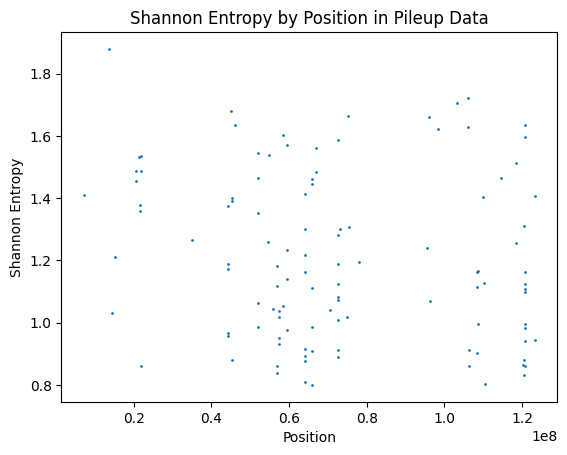

In [67]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.show()

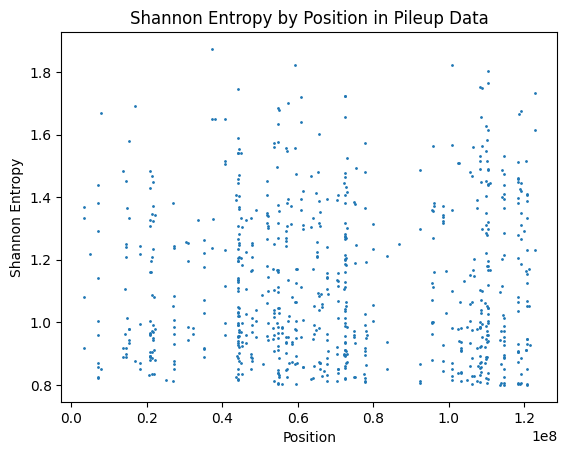

In [93]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.show()

In [ ]:
subpup['adj_shannon'] = (subpup['shannon']/subpup['base_count'])*subpup['base_count']

np.unique(subpup['adj_shannon']-subpup['shannon'])

In [69]:
min(subpup['pos']), max(subpup['pos'])

(7206931, 123291165)

In [70]:
threshold = 1000

diff = subpup['pos'].diff()
group_indices = np.where(diff > threshold)[0]
groups = np.split(subpup['pos'], group_indices + 1)

num_components_list = []
sum_diff_list = []
min_pos_list = []
max_pos_list = []

for group in groups:
    num_components = len(group)
    sum_diff = group.diff().sum()
    min_pos = group.min()
    max_pos = group.max()

    num_components_list.append(num_components)
    sum_diff_list.append(sum_diff)
    min_pos_list.append(min_pos)
    max_pos_list.append(max_pos)

result = {
    'Numbers': num_components_list,
    'Differences': sum_diff_list,
    'Min Pos': min_pos_list,
    'Max Pos': max_pos_list
}
result=pd.DataFrame(result)

result=result[(result['Numbers']>3) & (result['Differences']!=0)]
result=result.sort_values('Differences')
result

,Numbers,Differences,Min Pos,Max Pos
12,4,2323.0,44296030,44298353
71,4,2485.0,120784398,120786883
32,5,1883839.0,64085018,65968857
73,4,2501829.0,120789281,123291110
30,4,4496662.0,59586214,64082876


In [97]:
threshold = 1000

diff = subpup['pos'].diff()
group_indices = np.where(diff > threshold)[0]
groups = np.split(subpup['pos'], group_indices + 1)

num_components_list = []
sum_diff_list = []
min_pos_list = []
max_pos_list = []

for group in groups:
    num_components = len(group)
    sum_diff = group.diff().sum()
    min_pos = group.min()
    max_pos = group.max()

    num_components_list.append(num_components)
    sum_diff_list.append(sum_diff)
    min_pos_list.append(min_pos)
    max_pos_list.append(max_pos)

result = {
    'Numbers': num_components_list,
    'Differences': sum_diff_list,
    'Min Pos': min_pos_list,
    'Max Pos': max_pos_list
}
result=pd.DataFrame(result)

result=result[(result['Numbers']>9) & (result['Differences']!=0)]
result=result.sort_values('Differences')
result

,Numbers,Differences,Min Pos,Max Pos
380,10,7346.0,118387356.0,118394702.0
356,15,15961.0,110377698.0,110393659.0
79,10,16602.0,44302414.0,44319016.0
256,10,214746.0,77890874.0,78105620.0
238,10,251918.0,72654499.0,72906417.0
376,16,3783336.0,114576036.0,118359372.0


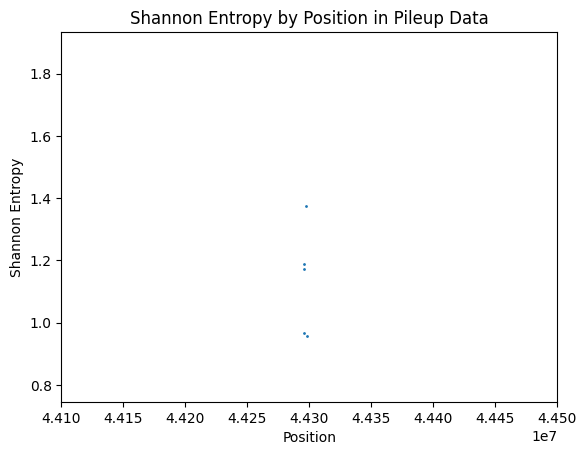

In [72]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(44100000,44500000)
plt.show()

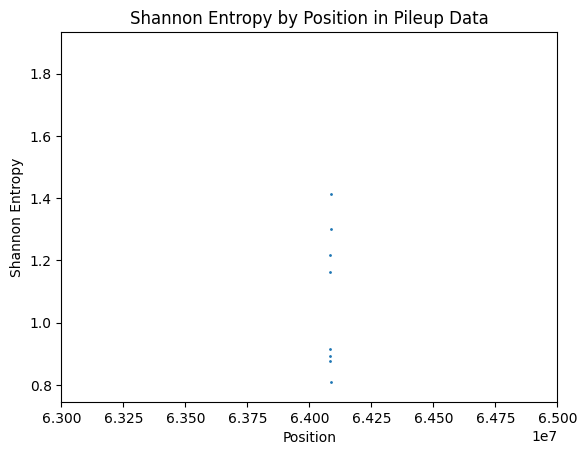

In [71]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(63000000,65000000)
plt.show()

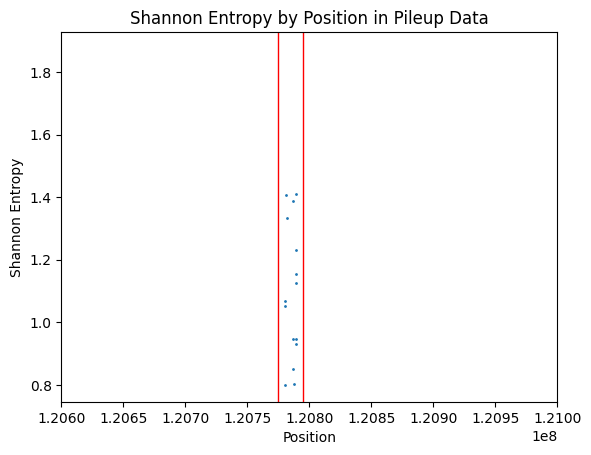

In [112]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(120600000,121000000)
plt.axvline(120775000, c='red', linewidth=1)
plt.axvline(120795000, c='red', linewidth=1)
plt.show()

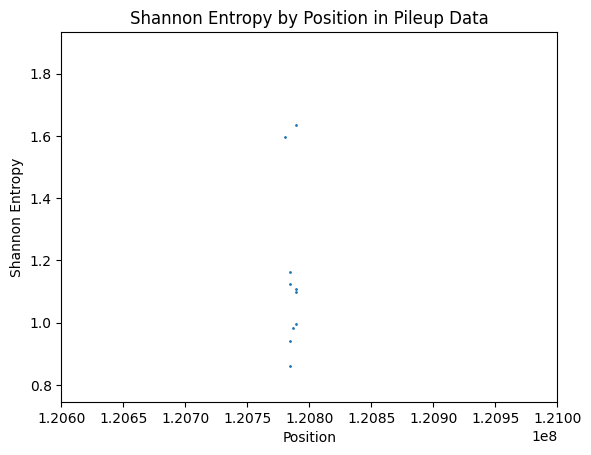

In [73]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(120600000,121000000)
plt.show()

In [37]:
subpup2 = pup[(pup['shannon'] > 0.8) & (pup['pos'] > 1.206e8) & (pup['pos'] < 1.210e8)]
len(subpup2)

19

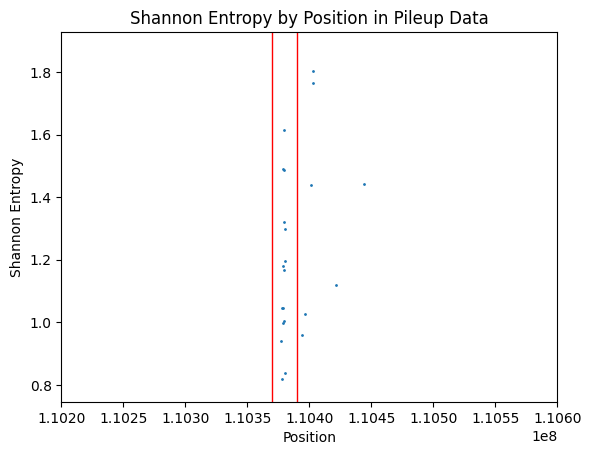

In [106]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(110200000,110600000)
plt.axvline(110370000, c='red', linewidth=1)
plt.axvline(110390000, c='red', linewidth=1)
plt.show()

In [107]:
subpup3 = pup[(pup['shannon'] > 0.8) & (pup['pos'] > 1.1037e8) & (pup['pos'] < 1.1039e8)]
len(subpup3)

15

In [38]:
subpup2

,chrom,pos,ref,count,basereads,quals,matches,base_count,countA,countT,countG,countC,shannon
17515495,chr9,120780456,N,187,>>>>GGGGGGGGGGGAGGGGAGGGGAGGGAGGAATTTTGTGTTTGT...,GIDDG@3IGHB:G@GIIHIGHHIBHA?IH=DIHHIGIIHIHIIIGH...,GGGGGGGGGGGAGGGGAGGGGAGGGAGGAATTTTGTGTTTGTTGTG...,183,0.103825,0.060109,0.786885,0.049180,1.068908
17515596,chr9,120780557,N,198,>>>>GGGGGGGCGGGG-2NNGCGGAGGCGGGGGGAGGGGGGGGGGG...,GIDDAF@7IIHIHG>DICIGG@HIHEHGGGIBGEBFIBHHFGGGHI...,GGGGGGGCGGGGNNGCGGAGGCGGGGGGAGGGGGGGGGGGGGAACG...,194,0.087629,0.005155,0.845361,0.061856,1.043189
17515609,chr9,120780570,N,192,>>>>GGGGGGGGGGGGGGGGGGAGGGGGGGGGGGGAGGGGGGGGGG...,GIDDIIIDDDH@IGGIHIIHIG?I>GG>DE:IDEBGHHIDGIIGG:...,GGGGGGGGGGGGGGGGGGAGGGGGGGGGGGGAGGGGGGGGGGGGGG...,188,0.186170,0.000000,0.739362,0.074468,1.052670
17515827,chr9,120780788,N,150,>>>>GGGGGGGGGGGGGGGGGGGGGGGGGGGGGAGGGGAGGGGGGG...,GIDDHE@GI=8HDIIIAHIIIIIHHIHBDDBI<IIGIIHFIEAHCE...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGAGGGGAGGGGGGGGGGG...,146,0.260274,0.061644,0.623288,0.054795,1.407908
17517027,chr9,120781988,N,172,>>>>GAGTGGAATGTGGTAAGTTGTAAAAAAGAAGGGGGGGGGGGG...,GIDDBGDH8<IDGIHFIHEIBII2GIBIBGBGDDBBEEGCGIG=GH...,GAGTGGAATGTGGTAAGTTGTAAAAAAGAAGGGGGGGGGGGGGGGG...,168,0.172619,0.077381,0.690476,0.059524,1.334387
17517099,chr9,120782060,N,219,>>>>AAAAA****GGAGGGGGAGGGGGAGAGGGGGGGGAGGGGGCA...,GIDDEIGD<DFGI?HHGI>IIGIIFHHIIIH4IDDHID>GHHII3H...,AAAAAGGAGGGGGAGGGGGAGAGGGGGGGGAGGGGGCAGGGGGAAG...,211,0.123223,0.000000,0.848341,0.028436,0.839708
17521665,chr9,120786626,N,105,GGGGGGGAAAAAAAAAAAAAAAAACGGGACGAGCAAGGCCGCGGGC...,8HI@IDGFIBIG1HGD8HGGHIIBBGBHBHGDEGGIDH5DIGIIBC...,GGGGGGGAAAAAAAAAAAAAAAAACGGGACGAGCAAGGCCGCGGGC...,105,0.295238,0.000000,0.561905,0.142857,1.387966
17521759,chr9,120786720,N,123,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,<GIGII<D?HDID@GHHH>IHEIGIH;G@IGIEEIGIE:BH>IAIE...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,123,0.073171,0.000000,0.821138,0.105691,0.852154
17521938,chr9,120786899,N,240,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGGGGG...,BGEI>?<<IHIICIIEG52HFBEGBB>HAIIBI;@GIIDG@ICHIH...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGGGGG...,235,0.148936,0.012766,0.795745,0.042553,0.945588
17522733,chr9,120787694,N,224,GGGGG-2NNGGG-2NNGG-2NNGGGG-2NNGG-2NNGGGGGGGGGG...,HIF:BGHGE@@GD?ADDBHHIABGI@CGDBH8IA>AIFDIDGGGIB...,GGGGGNNGGGNNGGNNGGGGNNGGNNGGGGGGGGGGGGGGGGGGGG...,220,0.031818,0.000000,0.881818,0.086364,0.854340


In [39]:
target = subpup2[['chrom','pos']]
target['start']=subpup['pos']-12
target['stop']=subpup['pos']+11
target = target.drop('pos', axis=1)
target['shannon'] = subpup[['shannon']]
target

<ipython-input-39-05e445ead626>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['start']=subpup['pos']-12
<ipython-input-39-05e445ead626>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['stop']=subpup['pos']+11


,chrom,start,stop,shannon
17515495,chr9,120780444,120780467,1.068908
17515596,chr9,120780545,120780568,1.043189
17515609,chr9,120780558,120780581,1.052670
17515827,chr9,120780776,120780799,1.407908
17517027,chr9,120781976,120781999,1.334387
17517099,chr9,120782048,120782071,0.839708
17521665,chr9,120786614,120786637,1.387966
17521759,chr9,120786708,120786731,0.852154
17521938,chr9,120786887,120786910,0.945588
17522733,chr9,120787682,120787705,0.854340


In [40]:
target.to_csv("target_mirlet7g.bed",header=None, index=False, sep='\t')  

In [113]:
!bedtools getfasta -fi GRCm39.genome.fa -bed target_mirlet7g.bed -fo target_mirlet7g.fa